### Step 1

Estimating the number of FLOPS in matrix multiplication.

In [1]:
import numpy as np

In [2]:

n = 10
u = np.random.random((n,n))
v = np.random.random((n,n))
result = %timeit -o -n 100 -r 3 np.matmul(u,v)
step1_time = result.average


5.35 µs ± 2.24 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


We are multiplying an $n\times n$ matrix $u$ with another $n\times n$ matrix $v$.
The resulting product matrix $uv$ is also $n\times n$. 
Each of the elements of $uv$ is calculated after $n$ multiplications and approximately $n$ additions (technically it is $n-1$ additions, but for asymptotic analysis, using $n$ is good enough and is more calculation friendly.) 
So, we expect $2n$ FLOPS per entry in $uv$ and so $n^{2} \times 2n = 2n^{3}$ FLOPS for the entire matrix multiplication.
Now assuming the FLOPS take up the majority of the time(i do not know how numpy.matmul is internally implemented, so i cannot take into account other portions of the code that consume significant times.), the time taken for one FLOP is $\frac{total\,time}{2n^3}$

### Step 2
comapring the computational power of the CPU to the workload of matrix multiplication

In [3]:
flops_time = step1_time/(2*n**3)
flops_time
print(f"{(1/(flops_time*10**9)):.2f} GFLOPS per second")

0.37 GFLOPS per second


CPU frequency on my device:
get this after executing:
```shell
sysctl hb.tbfrequency
```
from the terminal-
24MHz/cycles per second(this is the power of 8 cores though)     
How many FLOPs per second, given one FLOP per cycle?

In [4]:
gflops_per_second = 2*n**3 * 0.024
gflops_per_second

48.0

Assuming the workload is evenly spread across the 8 cores(is this reasonable?) we get an average of about 6 GFLOPS , which is still 6 times the approximate amount of work needed for matmul.

### Step 3

### naive matrix multiplication

In [5]:

def matrix_multiply(u, v):
    m, n = u.shape
    n, p = v.shape
    res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res



In [6]:
naive_time = np.zeros(10)
np_time = np.zeros(10)

In [8]:
for i in range(8):
    dim = 2**i
    U = np.random.random((dim,dim))
    V = np.random.random((dim,dim))
    result_naive = %timeit -o -n 10 -r 3 matrix_multiply(U,V)
    naive_time[i] = result_naive.average

3.55 µs ± 960 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)
8.84 µs ± 582 ns per loop (mean ± std. dev. of 3 runs, 10 loops each)
62.6 µs ± 11 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
409 µs ± 7.43 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
2.04 ms ± 282 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
14.2 ms ± 285 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
111 ms ± 146 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


KeyboardInterrupt: 

I could have used the same for loop to update both the np arrays simultaneoulsy, but i chose to do it separately, to understand how many values i could calculate without crossing the time limits.   
current time limit: 30sec

In [ ]:
for j in range(10):
    dim = 2**j
    U = np.random.random((dim,dim))
    V = np.random.random((dim,dim))
    result_np = %timeit -o -n 100 -r 3 np.matmul(U,V)
    np_time[j] = result_np.average

In [ ]:
import matplotlib.pyplot as plt
dimensions = np.arange(1,10)
plt.figure()
plt.plot(2**dimensions[:8], naive_time[:8],label="matrix_multiply")
plt.plot(2**dimensions[:9], np_time[:9],label="np.matmul")
plt.xlabel(" dimensions of the matrix")
plt.ylabel("time taken to multiply the matrices in ms")
plt.legend()
plt.show()

since the matrix_multiply function just shot off even before the matmul function could show any variation, i plot time vs dimensions for np.matmul alone, under 10 sec

In [10]:
np_time_new = np.zeros(100)
import time
i = 0
current_time = start_time = time.time()

while(current_time-start_time<=10):
    dim = 2**i
    U = np.random.random((dim,dim))
    V = np.random.random((dim,dim))
    result_np = %timeit -o -n 100 -r 3 np.matmul(U,V)
    np_time_new[i] = result_np.average
    i+=1
    current_time = time.time()
print(f"number of iterations so far:{i}")
    

1.12 µs ± 145 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.23 µs ± 208 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.05 µs ± 21.2 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.14 µs ± 17.8 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.51 µs ± 18.6 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
7.58 µs ± 5.25 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
22.2 µs ± 417 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
The slowest run took 7.35 times longer than the fastest. This could mean that an intermediate result is being cached.
231 µs ± 213 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
777 µs ± 331 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
3.43 ms ± 358 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


KeyboardInterrupt: 

In [ ]:

dimension = np.arange(1,12)
plt.figure()
plt.plot(2**dimension, np_time_new[:11],label="np.matmul")
plt.xlabel(" dimensions of the matrix")
plt.ylabel("time taken to multiply the matrices in x10^4 ms")
plt.legend()
plt.show()

### some observations:
- clearly `np.matmul` takes far less time to do the job than the user defined function `matrix_mutliply`.
- the rise in the time taken by `matmul` is gradual and is expected as the internal implementation of `np.matmul` is designed for heavily optimised performance

### estimated vs actual number of flops
estimated FLOPS = $2n^3$    
actual FLOPS = $CPU\,frequecy\times time\,taken$   
We do notice that the observed times for `np.matmul` are very far away from the estimated times, while those of the user defined function seems to atleast show some correlation.

### for `np.matmul`

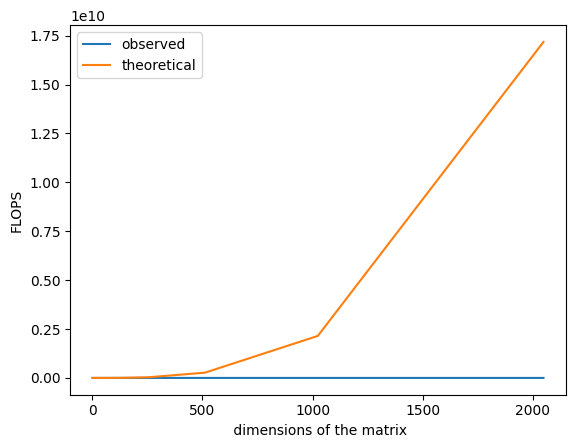

In [11]:

dimension = np.arange(1,12)
plt.figure()
plt.plot(2**dimension, 24*10**6*np_time_new[:11],label="observed")
plt.plot(2**dimension,2*(2**dimension)**3,label="theoretical")
plt.xlabel(" dimensions of the matrix")
plt.ylabel("FLOPS")
plt.legend()
plt.show()

### for matrix_multiply

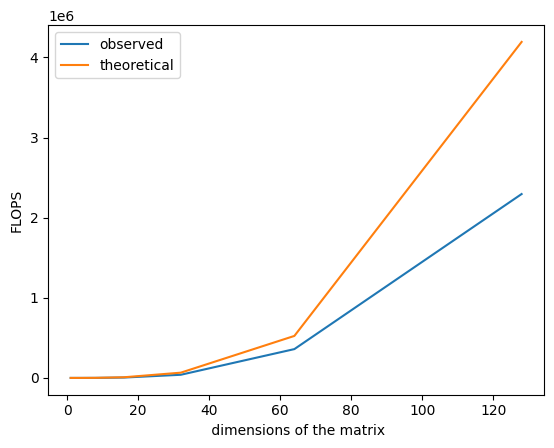

In [12]:
dimension = np.arange(8)
plt.figure()
plt.plot(2**dimension, 2.4*10**6*naive_time[:8],label="observed")
plt.plot(2**dimension,2*(2**dimension)**3,label="theoretical")
plt.xlabel(" dimensions of the matrix")
plt.ylabel("FLOPS")
plt.legend()
plt.show()

### Step 3
introducing cython implementations for python functions

In [14]:
%reload_ext Cython

In [15]:
import cython

### entry level cython 

In [16]:
%%cython -a

# @cython.boundscheck(False)
# @cython.wraparound(False)
# def cy_matmul(float[:,:] u, float[:,:] v, float[:,:] res):
def cy_matmul(u, v, res):
#     cdef int m, n, p
#     cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res


In [17]:
U = np.random.random((50,50))
V = np.random.random((50,50))
U = U.astype(np.float32)
V = V.astype(np.float32)
res = np.zeros((100, 100), dtype=np.float32)
result_without_cython = %timeit -o -n 100 -r 3 matrix_multiply(U,V)
result_with_cython = %timeit -o -n 100 -r 3cy_matmul(U,V,res)
print(result_without_cython,result_with_cython)

36.2 ms ± 59.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
36.2 ms ± 59.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each) None


### there is no difference at all in the times taken by the naive and the cython implementation of matrix_multiply!
also since the the matrices are generated randomly, there is no point in recording time taken, the correlation will be obvious every time the code is run.

### defining data types of local variables

In [18]:
%%cython -a

# @cython.boundscheck(False)
# @cython.wraparound(False)
# def cy_matmul(float[:,:] u, float[:,:] v, float[:,:] res):
def cy_matmul1(u, v, res):
    cdef int m, n, p
    cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res


In [19]:
res = np.zeros((100, 100), dtype=np.float32)
result_with_cython1 = %timeit -o -n 100 -r 3 cy_matmul1(U,V,res)
print(result_with_cython1)


27.6 ms ± 149 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
27.6 ms ± 149 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


### removing the obligation of checking vailidity of inputs

In [20]:
%%cython -a

import cython
@cython.boundscheck(False)
# @cython.wraparound(False)
# def cy_matmul(float[:,:] u, float[:,:] v, float[:,:] res):
def cy_matmul2(u, v, res):
    cdef int m, n, p
    cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res


In [21]:
res = np.zeros((100, 100), dtype=np.float32)
result_with_cython2 = %timeit -o -n 100 -r 3 cy_matmul2(U,V,res)
print(result_with_cython2)


27.1 ms ± 29.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
27.1 ms ± 29.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


### all double

In [22]:
%%cython -a

import cython
@cython.boundscheck(False)
# @cython.wraparound(False)
def cy_matmul3(double[:,:] u, double[:,:] v, double[:,:] res):
# def cy_matmul2(u, v, res):
    cdef int m, n, p
    cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res


In [29]:
res = np.zeros((100, 100), dtype=np.double)
U = U.astype(np.double)
V = V.astype(np.double)
result_with_cython3 = %timeit -o -n 100 -r 3 cy_matmul3(U,V,res)
print(result_with_cython3)


145 µs ± 23.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
145 µs ± 23.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


### all float

In [32]:
%%cython -a

import cython
@cython.boundscheck(False)
# @cython.wraparound(False)
def cy_matmul4(float[:,:] u, float[:,:] v, float[:,:] res):
# def cy_matmul2(u, v, res):
    cdef int m, n, p
    cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res


In [33]:
res = np.zeros((100, 100), dtype=np.float32)
U = U.astype(np.float32)
V = V.astype(np.float32)
result_with_cython4 = %timeit -o -n 100 -r 3 cy_matmul4(U,V,res)
print(result_with_cython4)


135 µs ± 31.2 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
135 µs ± 31.2 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


### observations:
- the basic cython implementation did pretty much nothing
- the next update-changing the data types of the local variables actually made things worse(?)
- the next change- removing the check on bounds, did nothing much too.
- the biggest change in the time taken is observed when all arrays are defined as double, the time goes from milliseconds to microseconds.
- conversion to float did retain the efficiency of double more of less, no big change was observed.
- as for what cython offered, 135microseconds vs 35 ms- that is about 260 times less time needed to do the same computation.(obviously this value is bound to change depending on what random matrix you start with.)

In [34]:
print(f"the best optimisation with cython generated results in {result_with_cython4} \
while the function without any optimisation does the same job in {result_without_cython}")

the best optimisation with cython generated results in 135 µs ± 31.2 µs per loop (mean ± std. dev. of 3 runs, 100 loops each) while the function without any optimisation does the same job in 36.2 ms ± 59.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
